# Build seawater proximity suitablity layers for GRIDCERF


The following code was used to build the seawater proximity suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  2022 TIGER/Line® Shapefiles: Coastline
- **Description from Source**: The 2022 TIGER/Line Shapefiles contain current geographic extent and boundaries of both legal and statistical entities (which have no governmental standing) for the United States, the District of Columbia, Puerto Rico, and the Island areas. This vintage includes boundaries of governmental units that match the data from the surveys that use 2022 geography (e.g., the 2022 American Community Survey).
- **Source URL**:  https://www2.census.gov/geo/tiger/TIGER2022/COASTLINE/tl_2022_us_coastline.zip
- **Date Accessed**:  9/25/23
- **Citation**
>  US Census Bureau, 2022. TIGER/Line Shapefiles: Coastline. Geography Division, U.S. Census Bureau, https://www2.census.gov/geo/tiger/TIGER2022/COASTLINE/tl_2022_us_coastline.zip

- **Application**: Thermoelectric technologies with seawater cooling type need to be located within close proximity to seawater. The GRIDCERF seawater proximity layer eliminates all areas greater than 20 miles from the oceanic coastline.
________

### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [7]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF source data directory for the downloaded data
tech_specific_dir = os.path.join(gridcerf_dir, "source", "technology_specific")
state_waters_dir = os.path.join(tech_specific_dir,  "offshore_state_waters")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# state waters

state_waters_shpfile = os.path.join(state_waters_dir, 'tl_2022_us_coastline', "tl_2022_us_coastline.shp")

# output rasters
output_coast_file = os.path.join(technology_specific_dir, "gridcerf_seawater_proximity_20mi_buffer.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [8]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)

            # invert suitability
            burned = np.where(burned==1, 0, 1).astype(np.float64)            
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

<Axes: >

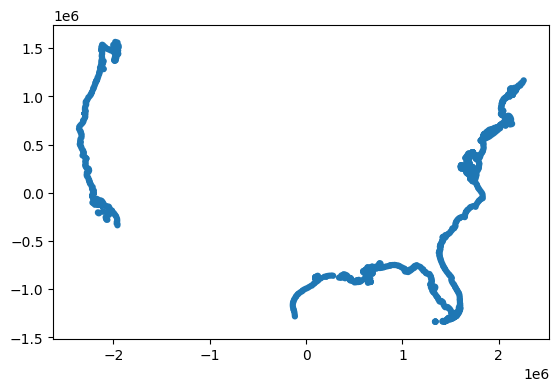

In [5]:
# read in shapefile  and project to our GRIDCERF projection
state_water_gdf = gpd.read_file(state_waters_shpfile).to_crs(crs)

# only keep areas within our GRIDCERF boundary
state_water_gdf = gpd.clip(state_water_gdf, bdf)

# keep only oceanic coastline
state_water_gdf = state_water_gdf[state_water_gdf.NAME != 'Great Lakes']

# add a 20-mile buffer to coastline
buffer = 20 * mi_to_meter
state_water_gdf["geometry"] = state_water_gdf["geometry"].buffer(buffer)

# add field to use for rasterization
state_water_gdf["value"] = 1

state_water_gdf.plot()

In [9]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=state_water_gdf, 
                 value_field="value",
                 output_raster=output_coast_file)